In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [236]:
## Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [237]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


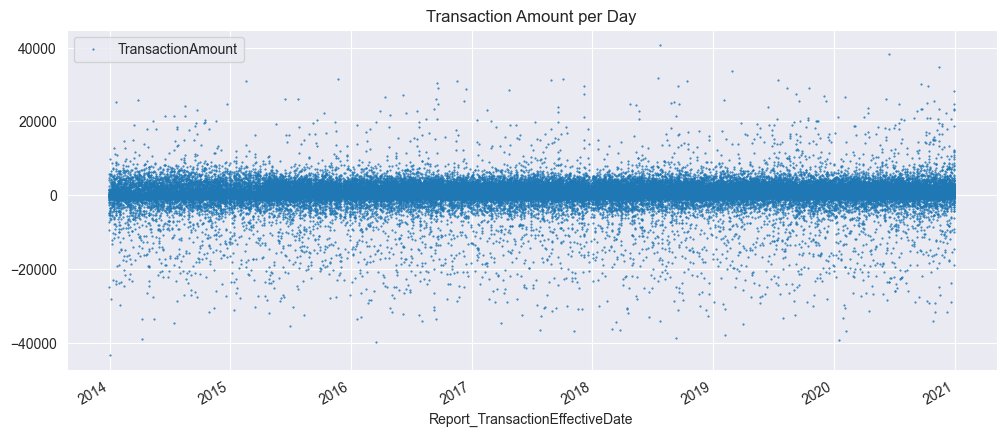

In [238]:
## Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [239]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D').ffill().bfill().to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-27,1763.692730
2020-12-28,1763.692730
2020-12-29,82156.304473


In [240]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 98


In [241]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)

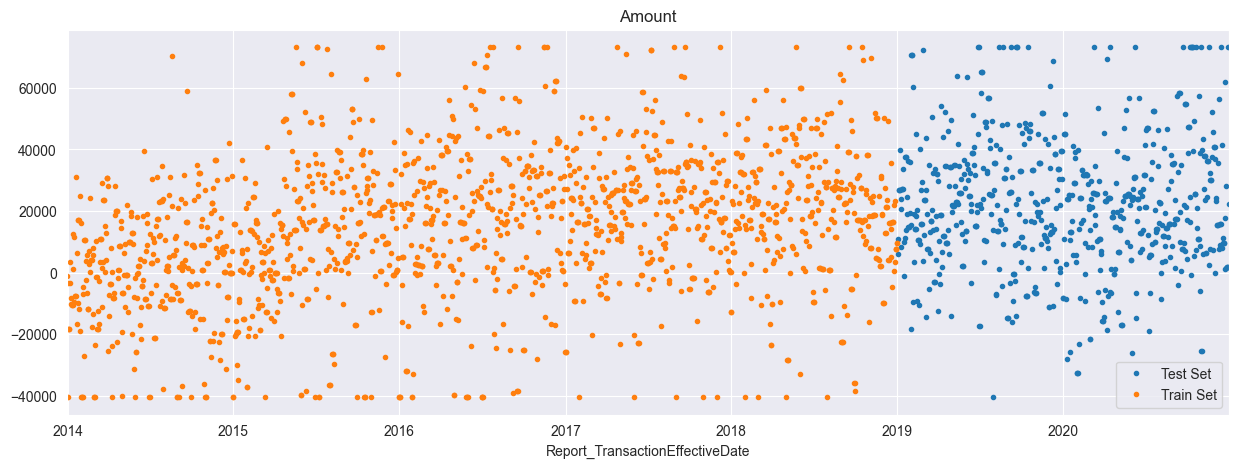

In [242]:
split_date = '1-Jan-2019'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()

In [243]:
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [244]:
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,39341.466845,10.580060
1,2013-12-31,-40417.380574,1.000000,0.693147
2,2014-01-01,-3465.890925,36952.489649,10.517415
3,2014-01-02,-40417.380574,1.000000,0.693147
4,2014-01-03,-18386.381900,22031.998674,10.000297
...,...,...,...,...
1824,2018-12-28,7577.044740,47995.425314,10.778882
1825,2018-12-29,7577.044740,47995.425314,10.778882
1826,2018-12-30,7577.044740,47995.425314,10.778882
1827,2018-12-31,9481.245786,49899.626360,10.817789


In [245]:
%%time
model = Prophet(
    seasonality_prior_scale=15,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  
    changepoint_prior_scale=0.1,
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=12) 
model.add_seasonality(name='weekly', period=7, fourier_order=18)  
model.add_seasonality(name='yearly', period=365.25, fourier_order=25)

model.fit(data_train_prophet)

12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 297 ms
Wall time: 602 ms


In [246]:
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,10.909292,6.356517,10.591616,10.909292,10.909292,-2.378907,-2.378907,-2.378907,-1.730739,...,-0.031994,-0.031994,-0.031994,-0.616174,-0.616174,-0.616174,0.0,0.0,0.0,8.530385
1,2019-01-03,10.909502,7.221212,11.497611,10.909502,10.909502,-1.589781,-1.589781,-1.589781,-0.953598,...,-0.049327,-0.049327,-0.049327,-0.586856,-0.586856,-0.586856,0.0,0.0,0.0,9.319721
2,2019-01-04,10.909712,7.402916,11.670853,10.909712,10.909712,-1.440976,-1.440976,-1.440976,-0.725995,...,-0.164312,-0.164312,-0.164312,-0.550670,-0.550670,-0.550670,0.0,0.0,0.0,9.468736
3,2019-01-05,10.909923,7.985226,12.042251,10.909923,10.909923,-0.916785,-0.916785,-0.916785,-0.283331,...,-0.124718,-0.124718,-0.124718,-0.508736,-0.508736,-0.508736,0.0,0.0,0.0,9.993138
4,2019-01-06,10.910133,8.268503,12.534183,10.910133,10.910133,-0.517154,-0.517154,-0.517154,0.000802,...,-0.055651,-0.055651,-0.055651,-0.462305,-0.462305,-0.462305,0.0,0.0,0.0,10.392979


In [247]:
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2019-01-02,10.909292,6.356517,10.591616,10.909292,10.909292,-2.378907,-2.378907,-2.378907,-1.730739,...,-0.031994,-0.031994,-0.616174,-0.616174,-0.616174,0.0,0.0,0.0,8.530385,-35351.984779
1,2019-01-03,10.909502,7.221212,11.497611,10.909502,10.909502,-1.589781,-1.589781,-1.589781,-0.953598,...,-0.049327,-0.049327,-0.586856,-0.586856,-0.586856,0.0,0.0,0.0,9.319721,-29262.512247
2,2019-01-04,10.909712,7.402916,11.670853,10.909712,10.909712,-1.440976,-1.440976,-1.440976,-0.725995,...,-0.164312,-0.164312,-0.550670,-0.550670,-0.550670,0.0,0.0,0.0,9.468736,-27469.869081
3,2019-01-05,10.909923,7.985226,12.042251,10.909923,10.909923,-0.916785,-0.916785,-0.916785,-0.283331,...,-0.124718,-0.124718,-0.508736,-0.508736,-0.508736,0.0,0.0,0.0,9.993138,-18542.553495
4,2019-01-06,10.910133,8.268503,12.534183,10.910133,10.910133,-0.517154,-0.517154,-0.517154,0.000802,...,-0.055651,-0.055651,-0.462305,-0.462305,-0.462305,0.0,0.0,0.0,10.392979,-7788.649055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,11.061616,8.801044,12.851811,11.004317,11.117372,-0.219599,-0.219599,-0.219599,0.457564,...,-0.055651,-0.055651,-0.621512,-0.621512,-0.621512,0.0,0.0,0.0,10.842017,10706.029193
726,2020-12-28,11.061826,9.084057,13.198919,11.004400,11.117798,0.064829,0.064829,0.064829,0.361886,...,0.344777,0.344777,-0.641834,-0.641834,-0.641834,0.0,0.0,0.0,11.126655,27540.270676
727,2020-12-29,11.062036,8.676459,13.026756,11.004535,11.118223,-0.202503,-0.202503,-0.202503,0.368784,...,0.081225,0.081225,-0.652513,-0.652513,-0.652513,0.0,0.0,0.0,10.859533,11609.388052
728,2020-12-30,11.062246,8.150068,12.368273,11.004671,11.118648,-0.728565,-0.728565,-0.728565,-0.043012,...,-0.031994,-0.031994,-0.653560,-0.653560,-0.653560,0.0,0.0,0.0,10.333681,-9667.288420


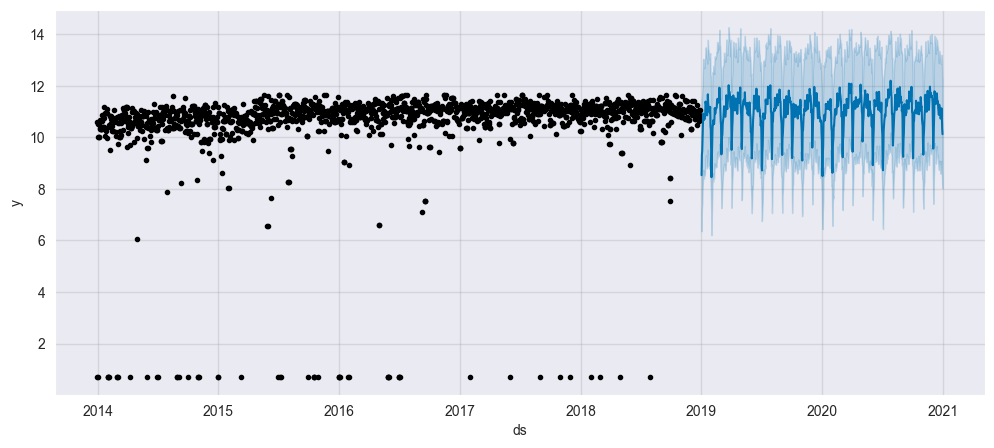

In [248]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

In [249]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


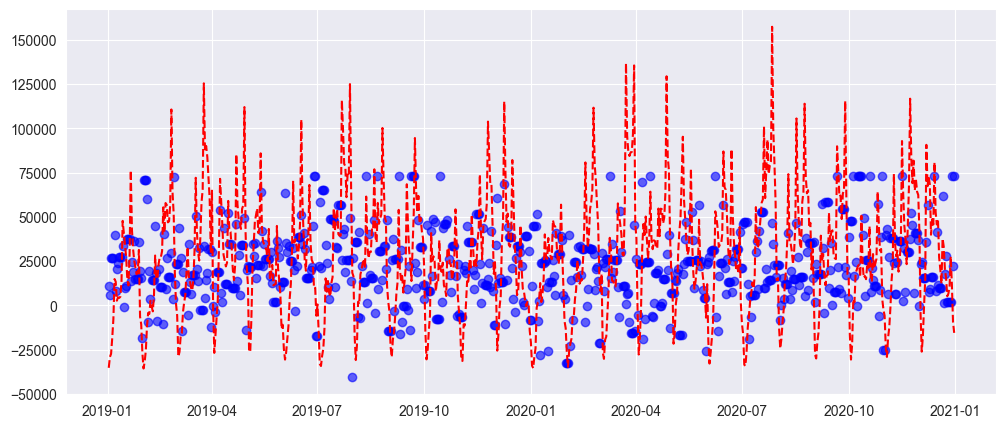

In [250]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [251]:
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2019-01-02,10.909292,6.356517,10.591616,10.909292,10.909292,-2.378907,-2.378907,-2.378907,-1.730739,...,-0.031994,-0.031994,-0.616174,-0.616174,-0.616174,0.0,0.0,0.0,8.530385,-35351.984779
1,2019-01-03,10.909502,7.221212,11.497611,10.909502,10.909502,-1.589781,-1.589781,-1.589781,-0.953598,...,-0.049327,-0.049327,-0.586856,-0.586856,-0.586856,0.0,0.0,0.0,9.319721,-29262.512247
2,2019-01-04,10.909712,7.402916,11.670853,10.909712,10.909712,-1.440976,-1.440976,-1.440976,-0.725995,...,-0.164312,-0.164312,-0.550670,-0.550670,-0.550670,0.0,0.0,0.0,9.468736,-27469.869081
3,2019-01-05,10.909923,7.985226,12.042251,10.909923,10.909923,-0.916785,-0.916785,-0.916785,-0.283331,...,-0.124718,-0.124718,-0.508736,-0.508736,-0.508736,0.0,0.0,0.0,9.993138,-18542.553495
4,2019-01-06,10.910133,8.268503,12.534183,10.910133,10.910133,-0.517154,-0.517154,-0.517154,0.000802,...,-0.055651,-0.055651,-0.462305,-0.462305,-0.462305,0.0,0.0,0.0,10.392979,-7788.649055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,11.061616,8.801044,12.851811,11.004317,11.117372,-0.219599,-0.219599,-0.219599,0.457564,...,-0.055651,-0.055651,-0.621512,-0.621512,-0.621512,0.0,0.0,0.0,10.842017,10706.029193
726,2020-12-28,11.061826,9.084057,13.198919,11.004400,11.117798,0.064829,0.064829,0.064829,0.361886,...,0.344777,0.344777,-0.641834,-0.641834,-0.641834,0.0,0.0,0.0,11.126655,27540.270676
727,2020-12-29,11.062036,8.676459,13.026756,11.004535,11.118223,-0.202503,-0.202503,-0.202503,0.368784,...,0.081225,0.081225,-0.652513,-0.652513,-0.652513,0.0,0.0,0.0,10.859533,11609.388052
728,2020-12-30,11.062246,8.150068,12.368273,11.004671,11.118648,-0.728565,-0.728565,-0.728565,-0.043012,...,-0.031994,-0.031994,-0.653560,-0.653560,-0.653560,0.0,0.0,0.0,10.333681,-9667.288420


In [252]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


In [253]:
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))

37750.83281189773

In [254]:
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

29311.750193890053

In [255]:
mean_absolute_percentage_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

388.5774356928454

In [256]:
last_date_in_test = data_test.index[-1]
last_date_in_test

Timestamp('2020-12-31 00:00:00')

In [257]:
future = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future}) 

forecast_future = model.predict(future_df)
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,11.062666,7.721738,11.946535,11.062666,11.062666,-1.223691,-1.223691,-1.223691,-0.431430,...,-0.164312,-0.164312,-0.164312,-0.627950,-0.627950,-0.627950,0.0,0.0,0.0,9.838976
1,2021-01-02,11.062876,6.758165,10.801676,11.062876,11.062876,-2.306818,-2.306818,-2.306818,-1.579662,...,-0.124718,-0.124718,-0.124718,-0.602438,-0.602438,-0.602438,0.0,0.0,0.0,8.756058
2,2021-01-03,11.063087,6.523729,10.785371,11.063087,11.063087,-2.355945,-2.355945,-2.355945,-1.730739,...,-0.055651,-0.055651,-0.055651,-0.569555,-0.569555,-0.569555,0.0,0.0,0.0,8.707142
3,2021-01-04,11.063297,7.770574,12.027559,11.063297,11.063297,-1.139168,-1.139168,-1.139168,-0.953598,...,0.344777,0.344777,0.344777,-0.530346,-0.530346,-0.530346,0.0,0.0,0.0,9.924129
4,2021-01-05,11.063507,7.938568,11.981003,11.063507,11.063507,-1.130770,-1.130770,-1.130770,-0.725995,...,0.081225,0.081225,0.081225,-0.486000,-0.486000,-0.486000,0.0,0.0,0.0,9.932737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,11.080525,9.488296,13.816135,11.078598,11.082480,0.684046,0.684046,0.684046,0.371074,...,-0.124718,-0.124718,-0.124718,0.437691,0.437691,0.437691,0.0,0.0,0.0,11.764571
86,2021-03-28,11.080735,9.911257,14.060755,11.078770,11.082727,0.878800,0.878800,0.878800,0.464891,...,-0.055651,-0.055651,-0.055651,0.469559,0.469559,0.469559,0.0,0.0,0.0,11.959535
87,2021-03-29,11.080945,10.096637,14.334526,11.078931,11.082974,1.236285,1.236285,1.236285,0.397431,...,0.344777,0.344777,0.344777,0.494077,0.494077,0.494077,0.0,0.0,0.0,12.317230
88,2021-03-30,11.081155,9.860246,14.241447,11.079075,11.083220,0.973494,0.973494,0.973494,0.381613,...,0.081225,0.081225,0.081225,0.510655,0.510655,0.510655,0.0,0.0,0.0,12.054649


In [258]:
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2021-01-01,11.062666,7.721738,11.946535,11.062666,11.062666,-1.223691,-1.223691,-1.223691,-0.431430,...,-0.164312,-0.164312,-0.627950,-0.627950,-0.627950,0.0,0.0,0.0,9.838976,-21667.883957
1,2021-01-02,11.062876,6.758165,10.801676,11.062876,11.062876,-2.306818,-2.306818,-2.306818,-1.579662,...,-0.124718,-0.124718,-0.602438,-0.602438,-0.602438,0.0,0.0,0.0,8.756058,-34069.344032
2,2021-01-03,11.063087,6.523729,10.785371,11.063087,11.063087,-2.355945,-2.355945,-2.355945,-1.730739,...,-0.055651,-0.055651,-0.569555,-0.569555,-0.569555,0.0,0.0,0.0,8.707142,-34372.443755
3,2021-01-04,11.063297,7.770574,12.027559,11.063297,11.063297,-1.139168,-1.139168,-1.139168,-0.953598,...,0.344777,0.344777,-0.530346,-0.530346,-0.530346,0.0,0.0,0.0,9.924129,-20001.268418
4,2021-01-05,11.063507,7.938568,11.981003,11.063507,11.063507,-1.130770,-1.130770,-1.130770,-0.725995,...,0.081225,0.081225,-0.486000,-0.486000,-0.486000,0.0,0.0,0.0,9.932737,-19824.752505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,11.080525,9.488296,13.816135,11.078598,11.082480,0.684046,0.684046,0.684046,0.371074,...,-0.124718,-0.124718,0.437691,0.437691,0.437691,0.0,0.0,0.0,11.764571,88195.614612
86,2021-03-28,11.080735,9.911257,14.060755,11.078770,11.082727,0.878800,0.878800,0.878800,0.464891,...,-0.055651,-0.055651,0.469559,0.469559,0.469559,0.0,0.0,0.0,11.959535,115881.954317
87,2021-03-29,11.080945,10.096637,14.334526,11.078931,11.082974,1.236285,1.236285,1.236285,0.397431,...,0.344777,0.344777,0.494077,0.494077,0.494077,0.0,0.0,0.0,12.317230,183095.740293
88,2021-03-30,11.081155,9.860246,14.241447,11.079075,11.083220,0.973494,0.973494,0.973494,0.381613,...,0.081225,0.081225,0.510655,0.510655,0.510655,0.0,0.0,0.0,12.054649,131478.325832


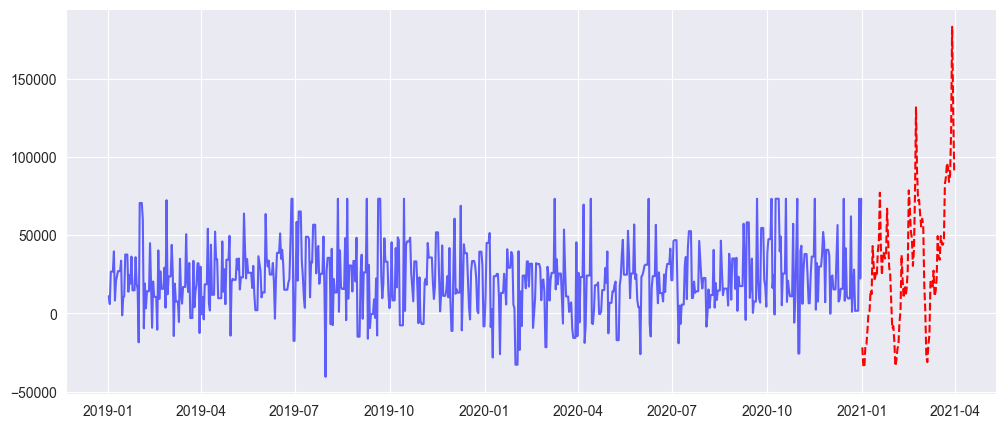

In [259]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(forecast_future['ds'], forecast_future["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [260]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecast_future['ds'].dt.date,
    'TotalPredictedAmount': forecast_future['yhat_original']
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results_prophet_2.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -21667.88
1  Precision Analyst  2021-01-02             -34069.34
2  Precision Analyst  2021-01-03             -34372.44
3  Precision Analyst  2021-01-04             -20001.27
4  Precision Analyst  2021-01-05             -19824.75
